<a href="https://colab.research.google.com/github/Deividasbu/NLP-for-Products-Clustering/blob/main/Products-Clustering-Using-NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Scraped Data Analysis

## Part I. Using the Natural Language Processing and K-means to classify products into the categories

In [ ]:
from google.colab import data_table
data_table.enable_dataframe_formatter()

Importing the necessary dependencies and data

In [ ]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import text
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from nltk.tokenize import RegexpTokenizer
from nltk.stem.snowball import SnowballStemmer
# %matplotlib inline

In [1]:
df = pd.read_csv('task_train.csv')
df.head()

,sku_id,country_name,retailer,breadcrumbs,breadcrumbs_t,name,name_t,pack_size,pack_size_t,description_short,description_t_short,resnet50_labels_005,resnet50_labels_06,price,label,label_id
0,22790,USA,amazon,"[""""Beauty & Personal Care"""",""""Tools & Accessor...","[""""Beauty & Personal Care"""",""""Tools & Accessor...","Q-tips Cotton Swabs, 170 ct","Q-tips Cotton Swabs, 170 ct",NaN,NaN,q-tips cotton swabs have a wide variety of use...,q-tips cotton swabs have a wide variety of use...,Band_Aid~can_opener~screwdriver,NaN,2.01000,OUT OF SCOPE,1
1,60540,USA,Chewy,"[""""Dog"""",""""Bowls & Feeders"""",""""Fountains & Fil...","[""""Dog"""",""""Bowls & Feeders"""",""""Fountains & Fil...","Petmate Fresh Flow Replacement Filters, 6 count","Petmate Fresh Flow Replacement Filters, 6 count",8.3 x 0.6 ...,8.3 x 0.6 ...,description the petmate deluxe fresh flow repl...,description the petmate deluxe fresh flow repl...,Band_Aid~web_site,NaN,7.00000,OUT OF SCOPE,1
2,96170,United Kingdom,Asda,"[""""Free From"""",""""Free From Chilled & Meat"""",""""...","[""""Free From"""",""""Free From Chilled & Meat"""",""""...",ASDA Free From Plain Soya Yogurt,ASDA Free From Plain Soya Yogurt,500g,500g,net content 500 grams ℮ lifestyle suitable for...,net content 500 grams ℮ lifestyle suitable for...,lotion~sunscreen,sunscreen,1.26185,Plain Yoghurt,7
3,116045,USA,jet.com,"[""""Pantry & Household"""",""""Household Supplies""""...","[""""Pantry & Household"""",""""Household Supplies""""...","Off! Deep Woods Dry Aerosol, 4 Oz","Off! Deep Woods Dry Aerosol, 4 Oz",12,12,description specs includes 25% deet formula. p...,description specs includes 25% deet formula. p...,can_opener~face_powder~oil_filter~tennis_ball,NaN,6.21000,OUT OF SCOPE,1
4,120858,USA,CVS,"[""""Vitamins"""",""""Herbals""""]","[""""Vitamins"""",""""Herbals""""]",Nature's Answer Damiana Leaf Vegetarian Capsul...,Nature's Answer Damiana Leaf Vegetarian Capsul...,90 CT,90 CT,nature's answer capsules feature the highest q...,nature's answer capsules feature the highest q...,face_powder~pill_bottle~sunscreen,pill_bottle,8.49000,OUT OF SCOPE,1


In order to use NLP I need to have data which defines the product well. After some trials I decided to create another column consisting of the name and last two breadcrumbs of the product. I believe breadcrubs contains necessary information closely related to the product iteslf and it should improve classification.   
I decided to only leave last two breadcrumbs because further paths might give more noice than benefit. 

In [ ]:
modified_breadcrumbs_t = []
for i in df['breadcrumbs_t']:
  i = i.replace('[', '').replace(']', '').replace('""', '').replace('-','').replace(',',', ')
  i = i.split(",")
  modified_breadcrumbs_t.append(i[-3:])
df['breadcrumbs_t'] = [', '.join(x) for x in modified_breadcrumbs_t]

Joining information - adding product name and last two breadcrumbs together. This new column later on will be used to cluster the products.

In [ ]:
df['breadcrumbs_name_t'] = df[['breadcrumbs_t', 'name_t']].agg(', '.join, axis=1)

I now define some additional stop words and punctuations which will be used together with the English stop words list that is defaulted in the sklearn library. During the vectorization process, the tokens (stop words) included in the stop words list will not be included in the vectorization.

In [ ]:
additional_stop_w = ['.', ',', '"', "'", '?', '!', ':', ';', '(', ')', '[', ']', 
                     '{', '}',"%", '&', '-', '/', 'x', 'cm', 'kg', 'ml', 'g']

stop_words = text.ENGLISH_STOP_WORDS.union(additional_stop_w)

After that, to vectorize the tokens of each product tf-idf (term frequency-inverse document frequency) vectorizer is being used. It creates a vector of counts of each word in each description and then creates frequency vectors that account for the importance of a word in the whole text.   

tf-idf vectorizer can also be modified by writting our own function that performs the stemming and any other text processing. Here the function defined uses lemmatizer and tokenizer.   
There are various stemmers and lemmatizers that reduce words to their root forms. I do not actuall know the differences and excact working principle, but here I am using the SnowballStemmer and it seems it does its job quite good.   I also use regular expressions with another tokenizer that will further limit the tokens to vectorize. 

With stop words adjusted, stemming included, and further limitation of our token feature space with regular expressions is done, it is also possible to adjust the max_features parameter in the tf-idf vectorizer, which selects only the top max_features tokens ordered by their frequencies in the training text to be included in the vectorizing.

In [ ]:
stemmer = SnowballStemmer('english')
tokenizer = RegexpTokenizer(r'[a-zA-Z\']+')

def tokenize(text):
    return [stemmer.stem(word) for word in tokenizer.tokenize(text.lower())]

desc = df['breadcrumbs_name_t'].values

vectorizer = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize, max_features = 1000)
X = vectorizer.fit_transform(desc)
words = vectorizer.get_feature_names_out()
words[:30]

array(['absorb', 'accessori', 'acn', 'acryl', 'activ', 'adhes', 'adjust',
       'adult', 'advanc', 'age', 'aid', 'air', 'alcohol', 'allergi',
       'altern', 'anim', 'anti', 'apparel', 'appl', 'applianc', 'applic',
       'aqua', 'aquarium', 'arden', 'aroma', 'aromatherapi', 'art',
       'articl', 'assort', 'automat'], dtype=object)

We can see above how the tokens in the corpus that were vectorized for each document look like. The words are trunctaded and unique.

### K-means Clustering

Once the preprocessing of the words is done we can move to the clustering. K-means assigns data points to the nearest centroid. The number of centroids (clusters) should be provided and at least for me, finding the most suitable amount of clusters is usually tricky.   
There is an Elbow method for finding optimal amount of clusters, but sometimes it is still hard to find it.    
The idea of an elbow method is that the average of the squared distances from the cluster centers of the respective cluster is calculated (Euclidian distance) together with the sum of squared distances of samples to their closest cluster center. Then the values of clusters are iterated and distortions for each value of cluster are calculated. The optimal point of cluster should be at the point after which the distortion/inertia start decreasing in a linear fashion.  
From the plot below it is hard to tell where the line becomes way flatter. In my eyes it should be from 20 up to 40. However, when trying to cateogrise 20 clusters I noticed that some categories are way tooo broad, and when clusters size is 40, some categories overlap. Therefore the optimal number of clusters I chose to set is 30. 



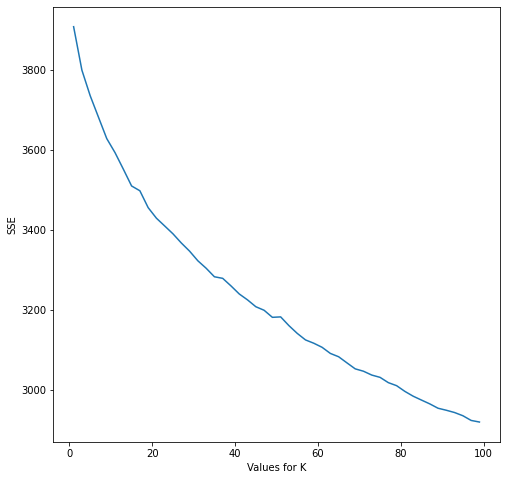

In [ ]:
distortion={}
for k in np.arange(1,100,2):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(X)
    distortion[k] = kmeans.inertia_
plt.figure(figsize=(8,8))
plt.plot(list(distortion.keys()),list(distortion.values()))
plt.xlabel('Number of Clusters K')
plt.ylabel('distortion')
plt.show();

In [ ]:
kmeans = KMeans(n_clusters = 30, n_init = 5, random_state=42)
kmeans.fit(X)

KMeans(n_clusters=30, n_init=5, random_state=42)

Once the data is clustered, we can print the number of a cluster and the most frequent words in that cluster. We can see that some clusters have words of a really similar topic. 

In [ ]:
common_words = kmeans.cluster_centers_.argsort()[:,-1:-11:-1]
for num, centroid in enumerate(common_words):
    print(str(num) + ' : ' + ', '.join(words[word] for word in centroid))

0 : health, pet, medic, pack, product, kitchen, beauti, set, bath, medicin
1 : care, bodi, skin, mask, face, person, health, beauti, eye, oral
2 : shampoo, condition, hair, rins, dog, pet, care, clean, suppli, cat
3 : cat, pet, suppli, litter, toy, dog, bed, collar, anim, companion
4 : eau, fragranc, toilett, men, parfum, perfum, en, spray, cologn, edt
5 : makeup, brush, eye, tool, cosmet, eyelash, face, beauti, make, foundat
6 : nail, art, polish, manicur, design, care, tip, tool, sticker, pedicur
7 : seed, nut, fruit, organ, bean, veget, packag, food, drink, garden
8 : coffe, instant, tea, maker, capsul, beverag, drink, dose, singl, brew
9 : t, shirt, dress, sleev, women, blous, long, print, casual, r
10 : diaper, adult, wipe, babi, pamper, pant, care, pad, size, paper
11 : yogurt, dairi, yoghurt, natur, greek, egg, chees, fat, milk, plain
12 : shoe, pump, boot, women, leather, brush, heel, lace, slipper, men
13 : accessori, tool, power, saw, mirror, bathroom, case, holder, hand, bla

I now assign the number of a the cluster to each row by creating a new column.


In [ ]:
df['label_2'] = kmeans.labels_
df.head(5)

,sku_id,country_name,retailer,breadcrumbs,breadcrumbs_t,name,name_t,pack_size,pack_size_t,description_short,description_t_short,resnet50_labels_005,resnet50_labels_06,price,label,label_id,breadcrumbs_name_t,label_2
0,22790,USA,amazon,"[""""Beauty & Personal Care"""",""""Tools & Accessor...","Tools & Accessories, Cotton Balls & Swabs, ...","Q-tips Cotton Swabs, 170 ct","Q-tips Cotton Swabs, 170 ct",NaN,NaN,q-tips cotton swabs have a wide variety of use...,q-tips cotton swabs have a wide variety of use...,Band_Aid~can_opener~screwdriver,NaN,2.01000,OUT OF SCOPE,1,"Tools & Accessories, Cotton Balls & Swabs, ...",13
1,60540,USA,Chewy,"[""""Dog"""",""""Bowls & Feeders"""",""""Fountains & Fil...","Dog, Bowls & Feeders, Fountains & Filters","Petmate Fresh Flow Replacement Filters, 6 count","Petmate Fresh Flow Replacement Filters, 6 count",8.3 x 0.6 ...,8.3 x 0.6 ...,description the petmate deluxe fresh flow repl...,description the petmate deluxe fresh flow repl...,Band_Aid~web_site,NaN,7.00000,OUT OF SCOPE,1,"Dog, Bowls & Feeders, Fountains & Filters, P...",0
2,96170,United Kingdom,Asda,"[""""Free From"""",""""Free From Chilled & Meat"""",""""...","Cheese & Yogurts, Yogurts, Desserts & Cream",ASDA Free From Plain Soya Yogurt,ASDA Free From Plain Soya Yogurt,500g,500g,net content 500 grams ℮ lifestyle suitable for...,net content 500 grams ℮ lifestyle suitable for...,lotion~sunscreen,sunscreen,1.26185,Plain Yoghurt,7,"Cheese & Yogurts, Yogurts, Desserts & Cre...",11
3,116045,USA,jet.com,"[""""Pantry & Household"""",""""Household Supplies""""...","Household Supplies, Insect & Pest Control, ...","Off! Deep Woods Dry Aerosol, 4 Oz","Off! Deep Woods Dry Aerosol, 4 Oz",12,12,description specs includes 25% deet formula. p...,description specs includes 25% deet formula. p...,can_opener~face_powder~oil_filter~tennis_ball,NaN,6.21000,OUT OF SCOPE,1,"Household Supplies, Insect & Pest Control, ...",0
4,120858,USA,CVS,"[""""Vitamins"""",""""Herbals""""]","Vitamins, Herbals",Nature's Answer Damiana Leaf Vegetarian Capsul...,Nature's Answer Damiana Leaf Vegetarian Capsul...,90 CT,90 CT,nature's answer capsules feature the highest q...,nature's answer capsules feature the highest q...,face_powder~pill_bottle~sunscreen,pill_bottle,8.49000,OUT OF SCOPE,1,"Vitamins, Herbals, Nature's Answer Damiana Le...",15


And now manually assigning the name to each cluster. The cluster '0' seems not to have any specific topic therefore I assume this is a cluster of all the products with strange names and breadcrumbs. I name it as 'OUT OF SCOPE' since the algorithm did not manage to classify the products of this cluster to other, narrower clusters.  
The final column with my predictions (classification) is named label_2. 

In [ ]:
di = {0: "OUT OF SCOPE", 
      1: "Body Care Good", 
      2: "Hair Care Good",
      3: "Pet Care Good",
      4: "Parfume",
      5: "Makeup Good",
      6: "Nail Care Good",
      7: "Superfood",
      8: "Coffe Good",
      9: "Cloth",
      10: "Diaper",
      11: "Yogurt",
      12: "Shoes",
      13: "Home Accessory",
      14: "Baby Care Good",
      15: "Health Supplement",
      16: "House Appliance Good",
      17: "Hair Styling Good",
      18: "House Care Good",
      19: "Gift Set",
      20: "Fish Tank Care Good",
      21: "Cloth",
      22: "Foot Care Good",
      23: "Water",
      24: "Dog Care Good",
      25: "Hair Remover",
      26: "Food",
      27: "Leisure Good",
      28: "Parfume",
      29: "Cleaning Good",
      }

df['label_2'].replace(di, inplace=True)
df.head(5)

,sku_id,country_name,retailer,breadcrumbs,breadcrumbs_t,name,name_t,pack_size,pack_size_t,description_short,description_t_short,resnet50_labels_005,resnet50_labels_06,price,label,label_id,breadcrumbs_name_t,label_2
0,22790,USA,amazon,"[""""Beauty & Personal Care"""",""""Tools & Accessor...","Tools & Accessories, Cotton Balls & Swabs, ...","Q-tips Cotton Swabs, 170 ct","Q-tips Cotton Swabs, 170 ct",NaN,NaN,q-tips cotton swabs have a wide variety of use...,q-tips cotton swabs have a wide variety of use...,Band_Aid~can_opener~screwdriver,NaN,2.01000,OUT OF SCOPE,1,"Tools & Accessories, Cotton Balls & Swabs, ...",Home Accessory
1,60540,USA,Chewy,"[""""Dog"""",""""Bowls & Feeders"""",""""Fountains & Fil...","Dog, Bowls & Feeders, Fountains & Filters","Petmate Fresh Flow Replacement Filters, 6 count","Petmate Fresh Flow Replacement Filters, 6 count",8.3 x 0.6 ...,8.3 x 0.6 ...,description the petmate deluxe fresh flow repl...,description the petmate deluxe fresh flow repl...,Band_Aid~web_site,NaN,7.00000,OUT OF SCOPE,1,"Dog, Bowls & Feeders, Fountains & Filters, P...",OUT OF SCOPE
2,96170,United Kingdom,Asda,"[""""Free From"""",""""Free From Chilled & Meat"""",""""...","Cheese & Yogurts, Yogurts, Desserts & Cream",ASDA Free From Plain Soya Yogurt,ASDA Free From Plain Soya Yogurt,500g,500g,net content 500 grams ℮ lifestyle suitable for...,net content 500 grams ℮ lifestyle suitable for...,lotion~sunscreen,sunscreen,1.26185,Plain Yoghurt,7,"Cheese & Yogurts, Yogurts, Desserts & Cre...",Yogurt
3,116045,USA,jet.com,"[""""Pantry & Household"""",""""Household Supplies""""...","Household Supplies, Insect & Pest Control, ...","Off! Deep Woods Dry Aerosol, 4 Oz","Off! Deep Woods Dry Aerosol, 4 Oz",12,12,description specs includes 25% deet formula. p...,description specs includes 25% deet formula. p...,can_opener~face_powder~oil_filter~tennis_ball,NaN,6.21000,OUT OF SCOPE,1,"Household Supplies, Insect & Pest Control, ...",OUT OF SCOPE
4,120858,USA,CVS,"[""""Vitamins"""",""""Herbals""""]","Vitamins, Herbals",Nature's Answer Damiana Leaf Vegetarian Capsul...,Nature's Answer Damiana Leaf Vegetarian Capsul...,90 CT,90 CT,nature's answer capsules feature the highest q...,nature's answer capsules feature the highest q...,face_powder~pill_bottle~sunscreen,pill_bottle,8.49000,OUT OF SCOPE,1,"Vitamins, Herbals, Nature's Answer Damiana Le...",Health Supplement


Most popular labels predicted excluding `OUT OF SCOPE`

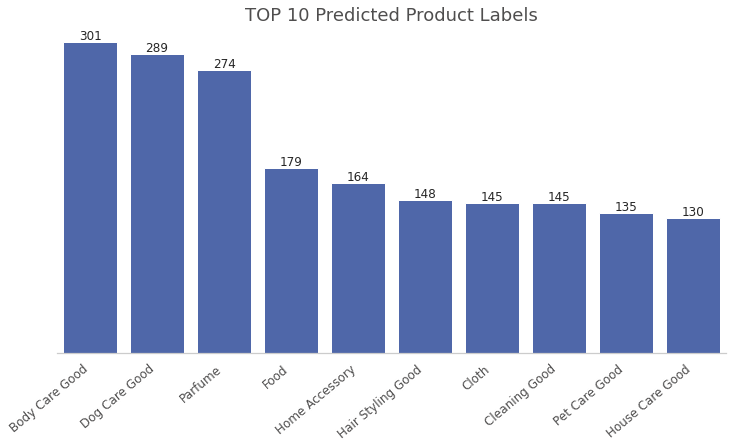

In [ ]:
labels = df.label_2.value_counts()
top_10_labels = labels[1:11]

plt.figure(figsize=(12, 6))
splot = sns.barplot(x=top_10_labels.index, y=top_10_labels.values, color='#4060b8')
splot.bar_label(splot.containers[0])
sns.set(style="whitegrid")
plt.xlabel('')
plt.ylabel('')
plt.title('TOP 10 Predicted Product Labels', size=18, color='#4f4e4e')
plt.xticks(size=12, color='#4f4e4e', rotation=40, ha='right')
plt.yticks([], [])
sns.despine(left=True)

### Some Reflection
After looking at the final data I noticed that some products are classified quite well and I think this result is pretty nice with this little amount of code (despite the fact that almost third of the data was not assigned a specific cluster). I also believe that some better results could be obtained with increasing the number of clusters - even though some categories might overlap, the 'OUT OF SCOPE' cluster might become way smaller meaning more products would have a meaningful cluster. This, however, would require a way more job to be done manually.  

## Part II. Analysis of Retailers

For the furhter analysis I will be using data about top 10 retailers by the number of products they have in the dataset. Below is the plot of those retailers, as well as locations from where most of the products comes from.

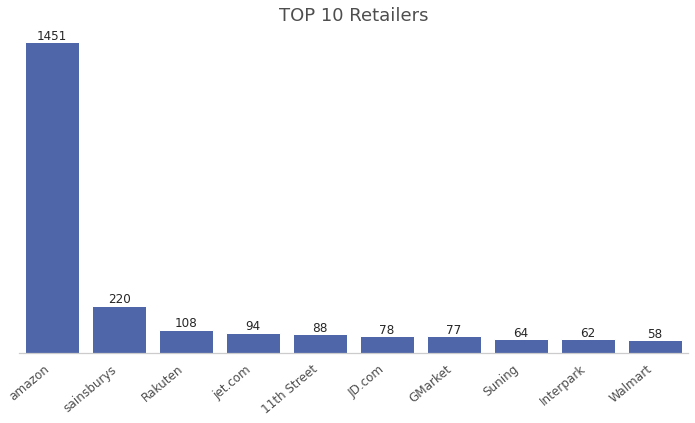

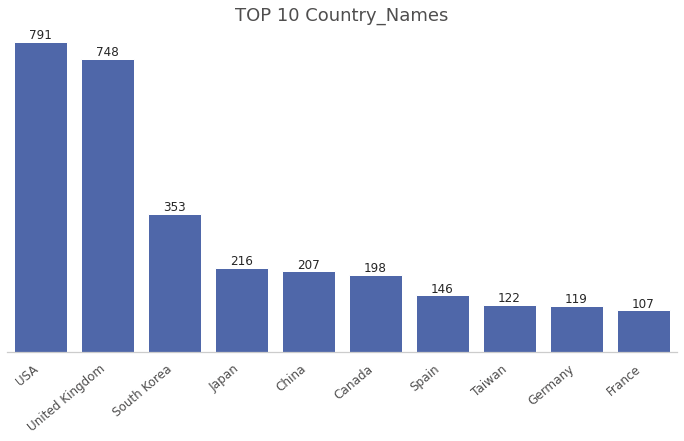

In [ ]:
for name in ['retailer', 'country_name']: 
  top_retailers = df[name].value_counts().head(10)

  plt.figure(figsize=(12, 6))
  splot = sns.barplot(x=top_retailers.index, y=top_retailers.values, color='#4060b8')
  splot.bar_label(splot.containers[0])
  sns.set(style="whitegrid")
  plt.xlabel('')
  plt.ylabel('')
  plt.title(f"TOP 10 {name.title()}s", size=18, color='#4f4e4e')
  plt.xticks(size=12, color='#4f4e4e', rotation=40, ha='right')
  plt.yticks([], [])
  sns.despine(left=True)
  plt.show()

### Analysing top retailer's text data
I have a hypothesis that if a retailer specifies in some specific cateogry of the products or the products scraped from a retailer falls in narrower cateogry, each retailer then can be classified by the most frequent words found in the text data of each retailer's products.  
To test this out, I want to group products by retailer and aggregate text about each product of that retailer.    
  
   
To obtain that, firstly I create column `breadcrumbs_name_desc_t` which contains the last two breadcrumbs and the name (as before) plus `description_t_short`.

In [ ]:
df['description_t_short'] = df['description_t_short'].astype(str)
df['description_t_short'] = df.description_t_short.str.replace('nan' , '')

df['breadcrumbs_name_desc_t'] = df[['breadcrumbs_t', 'name_t', 'description_t_short']].agg(', '.join, axis=1)

I then lemmatize text inside `breadcrumbs_name_desc_t` of each product and store it inside `lemmatized_desc` column which now contains lemmatized version product name, description, and the last two breadcrumbs.

In [ ]:
lemmatized = []
for i in df.breadcrumbs_name_desc_t:

  desc = [i]
  vectorizer2 = TfidfVectorizer(stop_words = stop_words, tokenizer = tokenize)

  try:
    X2 = vectorizer2.fit_transform(desc)
    word_features2 = vectorizer2.get_feature_names_out()
    lemmatized.append(word_features2)
  except ValueError:
    lemmatized.append(None)
    
df['lemmatized_desc'] = lemmatized

In order to groupby retailer's name, I convert lemmatized information from numpy array to string.

In [ ]:
def convert_to_string(s):
    s = np.array2string(s)
    s = s.replace('[', '').replace(']','').replace("' '",", ").replace("'",'')
    return s

df['lemmatized_desc'] = df['lemmatized_desc'].apply(convert_to_string)

Then the data is grouped by retailer and aggregated to concatenate lemmatized descriptions together. For each of the retailer in top 10, I plot 10 most frequent lemmatized words.

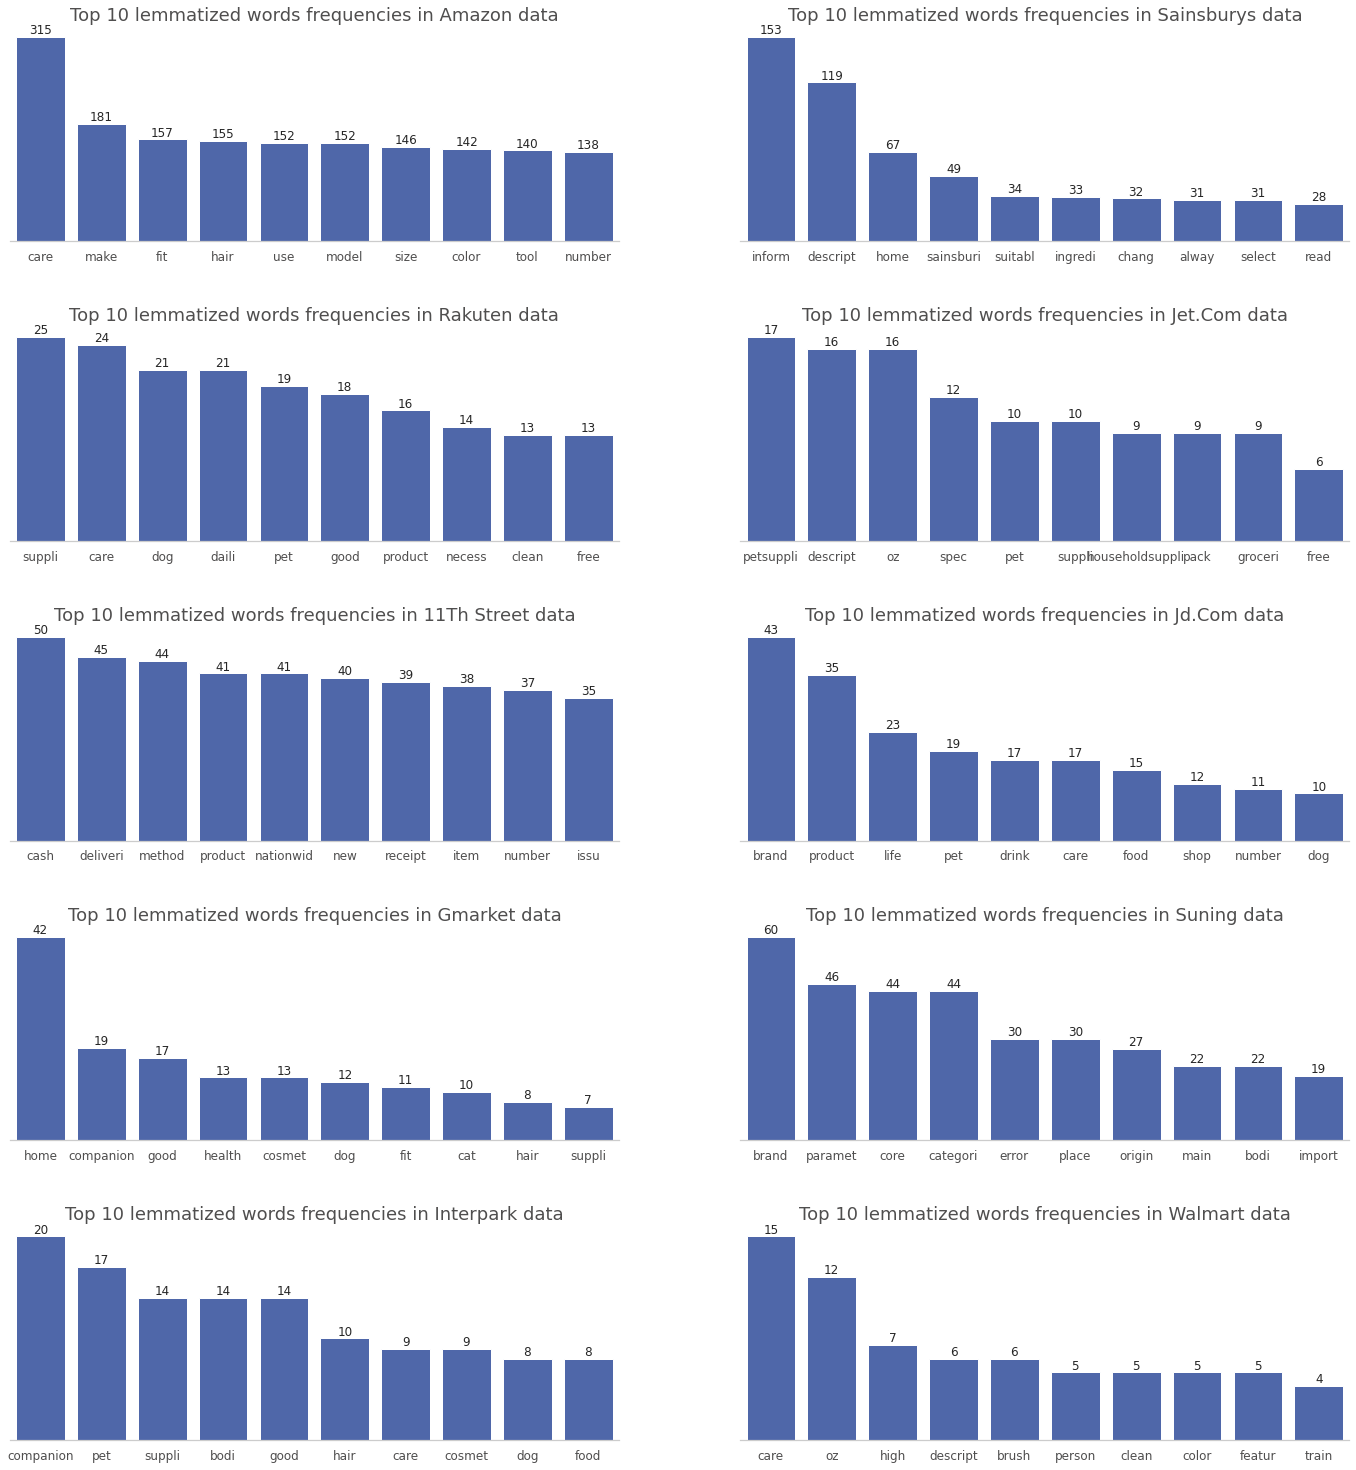

In [ ]:
from collections import Counter

grouped_lemma = df.groupby('retailer')['lemmatized_desc'].apply(','.join)
top_10_retailers = df.retailer.value_counts().head(10).index

plt.figure(figsize=(24,26))
position = 1

for i in top_10_retailers:

  plt.subplot(5, 2, position)

  data_set = grouped_lemma[i]

  split_it = data_set.split(', ')
  tf = Counter(split_it)

  y = [count for tag, count in tf.most_common(10)]
  x = [tag for tag, count in tf.most_common(10)]

  splot = sns.barplot(x=x, y=y, color='#4060b8')
  splot.bar_label(splot.containers[0])
  sns.set(style="whitegrid")
  plt.xlabel('')
  plt.ylabel('')
  plt.title(f"Top 10 lemmatized words frequencies in {i.title()} data", size=18, 
            color='#4f4e4e')
  plt.xticks(size=12, color='#4f4e4e')
  plt.yticks([], [])
  plt.subplots_adjust(hspace=0.4)
  sns.despine(left=True)
  position += 1

plt.show()

I would not say that lemmatized words summaries retailer and it's products really well. However, there are some retailers whose words are from a similar topic. For example, Interpark seems to be specializing more in pet care - we can see words such as companion, pet, care, dog, food. Other retailer's most frequent words do not fall into any specific topic and it feels like variuos products were scraped from widely specialized shops.

### Most popular predicted labels of top 10 retailers

It is also interesting to delve into labels predicted. Given there were only 30 of them, there might be retailers separability based on labels predicted (eg. maybe there are retailers whose labels predicted falls only into body/hair care?)  
  
In order to find this out I prepare my data by filtering it in such a way that only products from top 10 retailers are left. Then data is grouped by retailer and label while counting the number of products in each label.   

In [ ]:
top_retailer_data = df[df['retailer'].isin(top_10_retailers)]
grpup_top_retailer = top_retailer_data.groupby(['retailer', 'label_2'])['label_2'].count()
grpup_top_retailer = pd.DataFrame(grpup_top_retailer.to_frame())
grpup_top_retailer = grpup_top_retailer.rename(columns={'label_2':'label_2_counts'})
grpup_top_retailer = grpup_top_retailer.reset_index(level=['retailer', 'label_2'])
df.head(5)

,sku_id,country_name,retailer,breadcrumbs,breadcrumbs_t,name,name_t,pack_size,pack_size_t,description_short,description_t_short,resnet50_labels_005,resnet50_labels_06,price,label,label_id,breadcrumbs_name_t,label_2,breadcrumbs_name_desc_t,lemmatized_desc
0,22790,USA,amazon,"[""""Beauty & Personal Care"""",""""Tools & Accessor...","Tools & Accessories, Cotton Balls & Swabs, ...","Q-tips Cotton Swabs, 170 ct","Q-tips Cotton Swabs, 170 ct",NaN,NaN,q-tips cotton swabs have a wide variety of use...,q-tips cotton swabs have a wide variety of use...,Band_Aid~can_opener~screwdriver,NaN,2.01000,OUT OF SCOPE,1,"Tools & Accessories, Cotton Balls & Swabs, ...",Home Accessory,"Tools & Accessories, Cotton Balls & Swabs, ...","accessori, appli, art, babi, ball, beauti, car..."
1,60540,USA,Chewy,"[""""Dog"""",""""Bowls & Feeders"""",""""Fountains & Fil...","Dog, Bowls & Feeders, Fountains & Filters","Petmate Fresh Flow Replacement Filters, 6 count","Petmate Fresh Flow Replacement Filters, 6 count",8.3 x 0.6 ...,8.3 x 0.6 ...,description the petmate deluxe fresh flow repl...,description the petmate deluxe fresh flow repl...,Band_Aid~web_site,NaN,7.00000,OUT OF SCOPE,1,"Dog, Bowls & Feeders, Fountains & Filters, P...",OUT OF SCOPE,"Dog, Bowls & Feeders, Fountains & Filters, P...","bowl, charcoal, clean, cool, count, delux, des..."
2,96170,United Kingdom,Asda,"[""""Free From"""",""""Free From Chilled & Meat"""",""""...","Cheese & Yogurts, Yogurts, Desserts & Cream",ASDA Free From Plain Soya Yogurt,ASDA Free From Plain Soya Yogurt,500g,500g,net content 500 grams ℮ lifestyle suitable for...,net content 500 grams ℮ lifestyle suitable for...,lotion~sunscreen,sunscreen,1.26185,Plain Yoghurt,7,"Cheese & Yogurts, Yogurts, Desserts & Cre...",Yogurt,"Cheese & Yogurts, Yogurts, Desserts & Cre...","advic, allergen, allergi, asda, bacteri, bean,..."
3,116045,USA,jet.com,"[""""Pantry & Household"""",""""Household Supplies""""...","Household Supplies, Insect & Pest Control, ...","Off! Deep Woods Dry Aerosol, 4 Oz","Off! Deep Woods Dry Aerosol, 4 Oz",12,12,description specs includes 25% deet formula. p...,description specs includes 25% deet formula. p...,can_opener~face_powder~oil_filter~tennis_ball,NaN,6.21000,OUT OF SCOPE,1,"Household Supplies, Insect & Pest Control, ...",OUT OF SCOPE,"Household Supplies, Insect & Pest Control, ...","aerosol, chigger, control, deep, deet, descrip..."
4,120858,USA,CVS,"[""""Vitamins"""",""""Herbals""""]","Vitamins, Herbals",Nature's Answer Damiana Leaf Vegetarian Capsul...,Nature's Answer Damiana Leaf Vegetarian Capsul...,90 CT,90 CT,nature's answer capsules feature the highest q...,nature's answer capsules feature the highest q...,face_powder~pill_bottle~sunscreen,pill_bottle,8.49000,OUT OF SCOPE,1,"Vitamins, Herbals, Nature's Answer Damiana Le...",Health Supplement,"Vitamins, Herbals, Nature's Answer Damiana Le...","answer, capsul, care, constitu, ct, cultiv, da..."


After data is prepared, plotting happens again. I plot the same 10 most popular retailers and 5 labels with the highest count of products in those labels. The plots can be seen below.

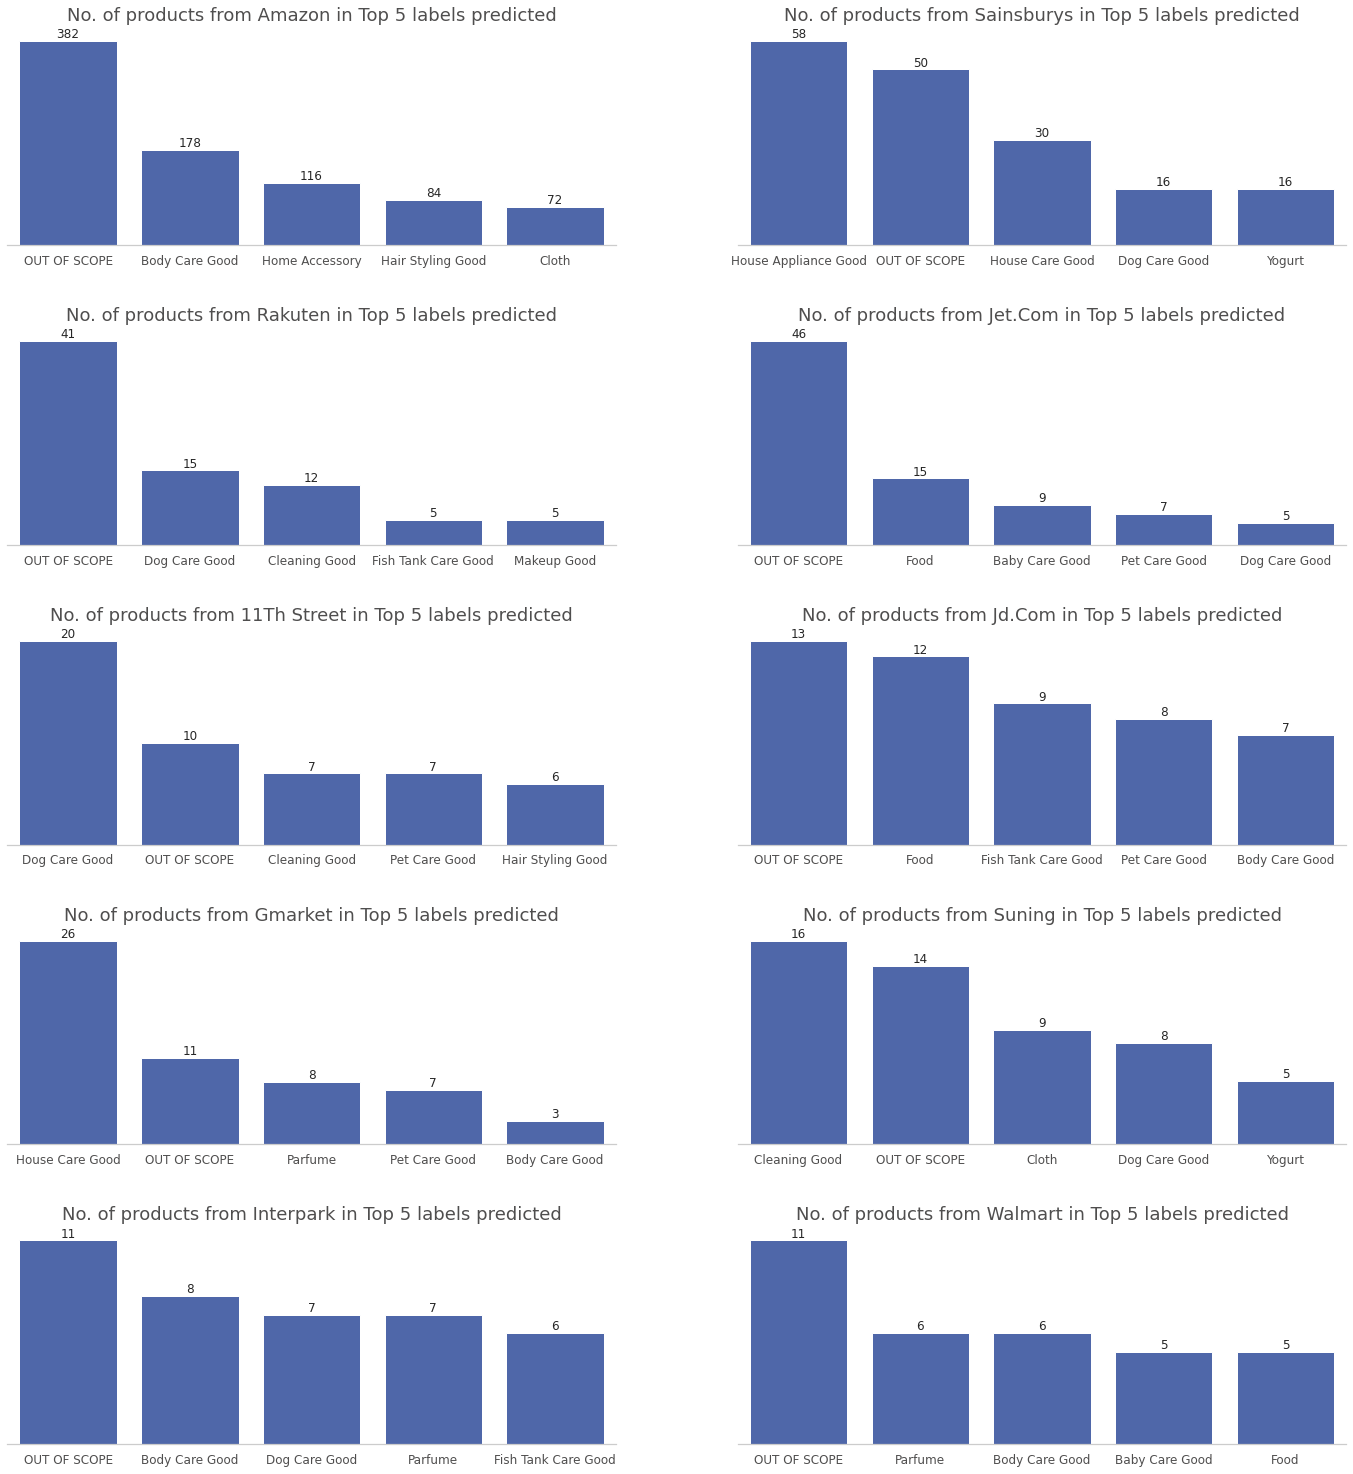

In [ ]:
plt.figure(figsize=(24,26))
position = 1

for retailer in top_10_retailers:
  data = grpup_top_retailer[grpup_top_retailer['retailer'] == retailer]
  data = data.sort_values(['label_2_counts'], ascending=False).head()

  plt.subplot(5, 2, position)
  splot = sns.barplot(x=data.label_2, y=data.label_2_counts, color='#4060b8')
  splot.bar_label(splot.containers[0])
  sns.set(style="whitegrid")
  plt.xlabel('')
  plt.ylabel('')
  plt.title(f"No. of products from {retailer.title()} in Top 5 labels predicted", size=18, 
            color='#4f4e4e', pad=10)
  plt.xticks(size=12, color='#4f4e4e')
  plt.yticks([], [])
  plt.subplots_adjust(hspace=0.4)
  sns.despine(left=True)
  position += 1

plt.show()

Again, it can be seen that all the most popular retailers supplies various products. It seems like almost all the retailers have some products for pet and body/hair care and no separability can be seen.   
I would reject my hypothesis that some separability of the retailers might exist based on lemmatized words (even though no statisticall tests were run).  
I would probably also reject the null stating existance of retailer's separability when it comes to the number of products in top categories.  

### Further Analysis

It would be interesting to analyse this data set with more accurate labels predicted. Maybe actually there is a separability between retailers? Or maybe separability exists between locations of the retailers?  
Also, what I would like to try is to assign those 5 most frequent lemmatized words of each retailer to each product of that retailer and then to try calssify products again. Maybe this would improve the accuracy a bit.  
Overall, I am quite happy I tried to analyse text data. At first it seemed there is nothing to analyse, but there actually is and I have just touchet the surface of that. 

## Part III. Label Prediciton

The following section tries to predict label column from other data columns. Given data is really imballanced, I've tried to predict label using Random Forest Classifier firstly accounding for the disbalance using Synthetic Minority Over-sampling Technique.

In [ ]:
df = pd.read_csv('task_train.csv')

### Data Preparation

I chose the following features for prediction: 
* breadcrumbs_t - the last breadcrumb from a product tree
* country_name
* retailer
* price
* resnet50_labels_005_1 - first category predicted by an image classifier
* resnet50_labels_005_2 - second category predicted by an image classifier

Modifying breatcrumbs to have only the last one

In [ ]:
modified_breadcrumbs_t = []
for i in df['breadcrumbs_t']:
  i = i.replace('[', '').replace(']', '').replace('""', '').replace('-','').replace(',',', ')
  i = i.split(",")
  modified_breadcrumbs_t.append(i[-1:])
df['breadcrumbs_t'] = [', '.join(x) for x in modified_breadcrumbs_t]

Narrowing down the dataset features

In [ ]:
df_of_interest = df.loc[:,['country_name',	'retailer', 'breadcrumbs_t',	
                           'resnet50_labels_005', 'price', 'label']]

Adding additional columns for the last two categories predicted by an image classifier

In [ ]:
df_of_interest['resnet50_labels_005'] = df_of_interest['resnet50_labels_005'].astype(str)

def change_resnet_1(input):
  input = input.split('~')[0]
  return input

def change_resnet_2(input):
  try:
    input = input.split('~')[1]
  except IndexError:
    input = 'NaN'
  return input

df_of_interest['resnet50_labels_005_1'] = df_of_interest['resnet50_labels_005'].apply(change_resnet_1)
df_of_interest['resnet50_labels_005_2'] = df_of_interest['resnet50_labels_005'].apply(change_resnet_2)

Filling missing prices with average price and checking for missing values

In [ ]:
df_of_interest.price = df_of_interest.price.fillna(df_of_interest.price.mean())
df_of_interest.isna().sum()

country_name             0
retailer                 0
breadcrumbs_t            0
resnet50_labels_005      0
price                    0
label                    0
resnet50_labels_005_1    0
resnet50_labels_005_2    0
dtype: int64

In [ ]:
df_of_interest.head(2)

,country_name,retailer,breadcrumbs_t,resnet50_labels_005,price,label,resnet50_labels_005_1,resnet50_labels_005_2
0,USA,amazon,Cotton Swabs,Band_Aid~can_opener~screwdriver,2.01,OUT OF SCOPE,Band_Aid,can_opener
1,USA,Chewy,Fountains & Filters,Band_Aid~web_site,7.00,OUT OF SCOPE,Band_Aid,web_site


Defining a function for encoding the categorical columns

In [ ]:
def encode_and_join(dataframe, feature_to_encode):
    dummies = pd.get_dummies(dataframe[[feature_to_encode]])
    result = pd.concat([dataframe, dummies], axis=1)
    result = result.drop([feature_to_encode], axis=1)
    return(result) 

Encoding categorical features

In [ ]:
features_to_encode = ['country_name',	'retailer', 'breadcrumbs_t',	'resnet50_labels_005_1', 'resnet50_labels_005_2']
for feature in features_to_encode:
    df_of_interest = encode_and_join(df_of_interest, feature)

Importing the necessary dependencies 

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

Splitting data into train and test samples while adding stratiffy=labels for equal proportions in labels

In [ ]:
labels = df_of_interest['label']
features = df_of_interest.drop(['label', 'resnet50_labels_005'], axis=1)


features_train, features_test, labels_train, labels_test = train_test_split(features, 
                                                                            labels, 
                                                                            test_size=0.2, 
                                                                            random_state=0,
                                                                            stratify=labels)

Using SMOTE to make data samples of different labels equal, checking whether it did its job

In [ ]:
oversampler=SMOTE(random_state=0)
os_features,os_labels=oversampler.fit_resample(features_train,labels_train)

len(os_labels[os_labels=="Wet Dog Food"])

2643

Fitting the model

In [ ]:
clf=RandomForestClassifier(random_state=0)
clf.fit(os_features,os_labels)

RandomForestClassifier(random_state=0)

Predicting labels for test data

In [ ]:
predictions=clf.predict(features_test)
actual=labels_test

Checking the accuracy score

In [ ]:
print(clf.score(features_test, labels_test))

0.740276035131744


It looks like model's accuracy is 74 percent, which is not that bad. However we should also look at the confusion matrix.

Plotting heatmap as a confusion matrix

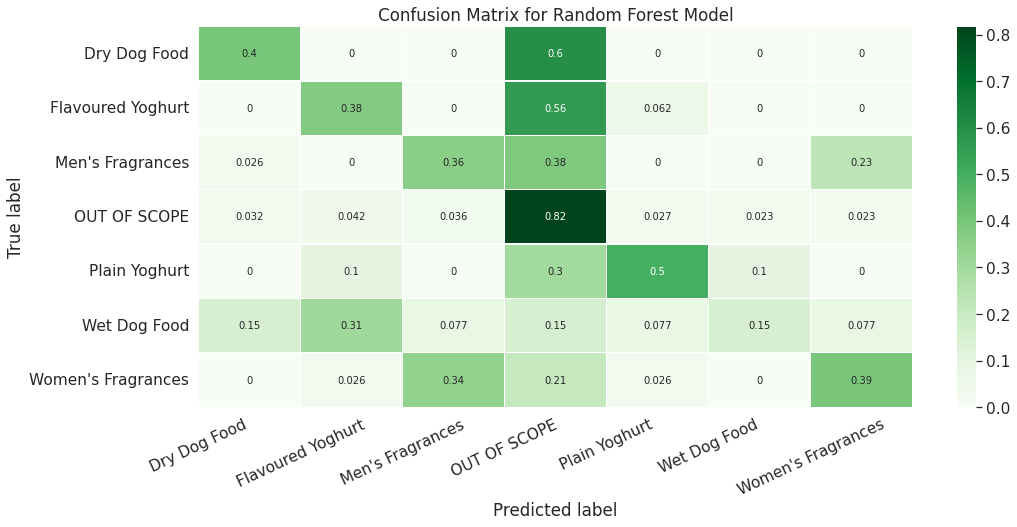

In [ ]:
matrix = confusion_matrix(actual, predictions)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

class_names = ['Dry Dog Food', 'Flavoured Yoghurt', "Men's Fragrances", 
               'OUT OF SCOPE', 'Plain Yoghurt', 'Wet Dog Food',    
               "Women's Fragrances"]
               
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

From the heatmap we can see that the model is not performing well. Diagonal shows accurate predictions, and for the smaller categories the percent of accurate predictions is really low - around 0.4.  
We can also see that one out thee times wet dog food is mixed with flavoured yogurt and quite the same happens with parfume of different sexes.  
Also, the majority of dry dog food and flavoured yoghurt products are assigned out of scope label which implies that it is hard for these two cateogires to stand out.  
These results could help us to improve the model by trying to choose/edit the features in order for the product to be better classified as its category.

### Possible Improvements

Due to the time constraint the performance of the model I have manage to achieve is quite weak. However, it should be possible to improve it by playing with different features, using K-Fold Cross Validation or using completely different model such as Logistic Regression with upsampling/downsampling.